In [1]:
import tensorflow as tf
print("Kullanılabilir GPU Sayısı: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import os
import time


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\ofaru\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\ofaru\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\ofaru\Desktop\GitHub\Gastroenterology-CNN-Comparison\cnnenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\ofaru\Desktop\GitHub\Gastroenterology-CNN-Comparison\cn

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\ofaru\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\ofaru\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\ofaru\Desktop\GitHub\Gastroenterology-CNN-Comparison\cnnenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\ofaru\Desktop\GitHub\Gastroenterology-CNN-Comparison\cn

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [ ]:
TRAIN_DIR = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\data\\prepared-data\\train"  
VAL_DIR = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\data\\prepared-data\\val"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8 # Kvasir-v2 için 8 sınıf var
EPOCHS = 35 # Denemeler için sonrasında artırılabilir
MODEL_SAVE_PATH = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\models\\" # Modellerin kaydedileceği yer

# Klasörün var olduğundan emin ol
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [ ]:
# 'categorical' kullanıyoruz çünkü 8 sınıfımız var
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_dataset.class_names
print("Sınıflar:", class_names)

# Performans için veri setlerini önbelleğe al
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 5592 files belonging to 8 classes.
Found 1600 files belonging to 8 classes.
Sınıflar: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [ ]:
def get_base_model():
    return applications.MobileNetV3Large(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')

def get_preprocessing_pipeline():
    return models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),
        layers.Rescaling(1./255)
    ], name="baseline_pipeline")

experiment_name = "mobilenetv3_large_baseline"


In [ ]:
def create_model(base_model_func, preprocessing_pipeline_func, num_classes):
    # Transfer Learning için temel modeli al ve dondur
    base_model = base_model_func()
    base_model.trainable = False
    
    # Ön işleme hattını al
    preprocessing_pipeline = preprocessing_pipeline_func()
    
    # Modeli birleştir
    inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
    x = preprocessing_pipeline(inputs)
    x = base_model(x, training=False) # 'training=False' önemlidir
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

print(f"Deney Başlatılıyor: {experiment_name}")
model = create_model(get_base_model, get_preprocessing_pipeline, NUM_CLASSES)
model.summary()

Deney Başlatılıyor: mobilenetv3_large_baseline
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 24s 2us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_pipeline (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
start_time = time.time()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)
end_time = time.time()
print(f"Eğitim Süresi: {end_time - start_time:.2f} saniye")

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 50s 261ms/step - accuracy: 0.1563 - loss: 2.1036 - val_accuracy: 0.2200 - val_loss: 1.9881
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 247ms/step - accuracy: 0.2207 - loss: 1.9849 - val_accuracy: 0.2988 - val_loss: 1.9186
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 240ms/step - accuracy: 0.2641 - loss: 1.9160 - val_accuracy: 0.3150 - val_loss: 1.8654
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 247ms/step - accuracy: 0.2899 - loss: 1.8690 - val_accuracy: 0.3363 - val_loss: 1.8237
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 219ms/step - accuracy: 0.3101 - loss: 1.8278 - val_accuracy: 0.3537 - val_loss: 1.7884
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 216ms/step - accuracy: 0.3133 - loss: 1.8007 - val_accuracy: 0.3681 - val_loss: 1.7589
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.3326 - loss: 1.7710 - val_accuracy: 0.3650 - val_loss: 1.7337
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 216ms/step - accuracy: 0.3407 - loss: 1

In [ ]:
model_filename = os.path.join(MODEL_SAVE_PATH, f"{experiment_name}.h5")
model.save(model_filename)
print(f"Model başarıyla kaydedildi: {model_filename}")

Model başarıyla kaydedildi: C:\Users\ofaru\Desktop\GitHub\Gastroenterology-CNN-Comparison\models\mobilenetv3_large_baseline.h5


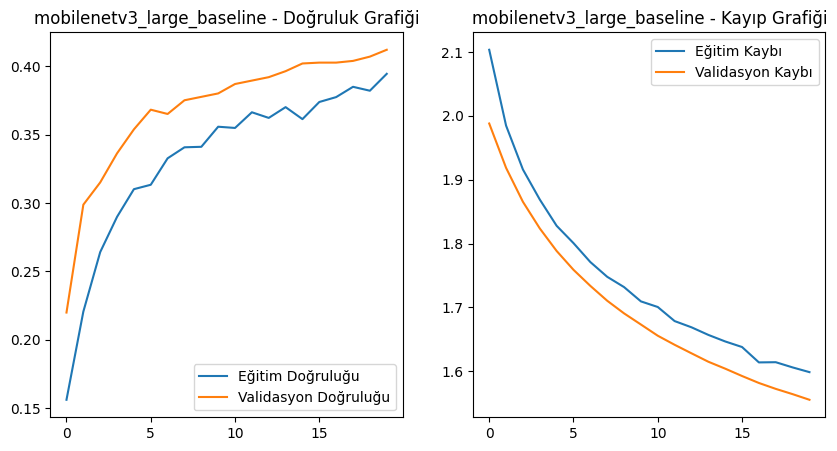

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Validasyon Doğruluğu')
plt.legend(loc='lower right')
plt.title(f'{experiment_name} - Doğruluk Grafiği')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Validasyon Kaybı')
plt.legend(loc='upper right')
plt.title(f'{experiment_name} - Kayıp Grafiği')
plt.show()